In [1]:
import LLMSR
import openai
import base64
import io
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch.nn

import sympy as sp
from sympy import symbols, simplify
from scipy.optimize import curve_fit
import re

from kan import *

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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",
)
LLMSR.llm.check_key_limit(client)

2025-03-11 03:05:58,437 - LLMSR.llm - INFO - API key check successful. Remaining limit: None


# Code Library

In [3]:
exp(1)

E

In [4]:
numpy_to_sympy = {
        "exp": exp, "sin": sin, "cos": cos, "log": log, "power": pow
    }

sympy_to_numpy = {
        "exp": "np.exp", "sin": "np.sin", "cos": "np.cos", "log": "np.log", "pow": "np.power"
    }

def subst_params(a, p):
    for i in range(len(p)):
        a = a.replace(f'params[{i}]', f'{p[i]:.4f}')
    return a
    
def simplify_expression(formula, N):
    # Define symbolic variables and functions
    variables = symbols(f'x0:{N+1}')
    used_functions = {name: numpy_to_sympy[name] for name in numpy_to_sympy if f'{name}' in formula}
    safe_dict = {f'x{i}': variables[i] for i in range(N+1)}
    safe_dict.update(used_functions)  # Add only used symbolic functions
    expr = simplify(eval(formula.replace("np.", ""), safe_dict))  # Remove "np." prefix for SymPy functions
    
    return str(expr)

def replace_floats_with_params(expr_str):
    # Extract float numbers using regex
    float_pattern = re.compile(r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?')
    float_matches = list(set(float_pattern.findall(expr_str)))
    
    # Sort floats by length to avoid partial replacements
    float_matches.sort(key=len, reverse=True)
    
    # Create symbolic parameters
    params = sp.symbols(f'param:{len(float_matches)}')
    param_values = [float(num) for num in float_matches]
    
    # Replace numeric values in the expression
    for i, num in enumerate(float_matches):
        expr_str = expr_str.replace(num, f'params[{i}]')
    
    return expr_str, param_values

def fit_curve(x, y, curve, params_initial):
    params_opt, _ = curve_fit(curve, x, y, p0=params_initial)
    residuals = y - curve(x, *params_opt)
    chi_squared = np.mean((residuals ** 2) / (np.square(curve(x, *params_opt))+1e-6))
    return params_opt, chi_squared 

def call_model_simplify(client, gpt_model="openai/gpt-4o", prompt="", system_prompt=None):
    if system_prompt is None:
        system_prompt = ("I have a function and an interval on which it is defined. Can you simplify it? Simplifications could include Taylor expansion of terms that are small in this interval, chopping terms that are small, and recognizing polynomials as the first few terms in a Taylor expansion. Please only output the final function as a string in the same format as the one that was given.")
    
    response = client.chat.completions.create(
    model = gpt_model,
    messages = [
        { "role": "system", 
         "content": system_prompt},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        }
        ],
        max_tokens=4096,
        )

    return response

# Try $(x^3 + \pi)^2$

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.08e-02 | test_loss: 1.06e-02 | reg: 3.15e+01 | : 100%|█| 100/100 [00:46<00:00,  2.15


saving model version 0.1


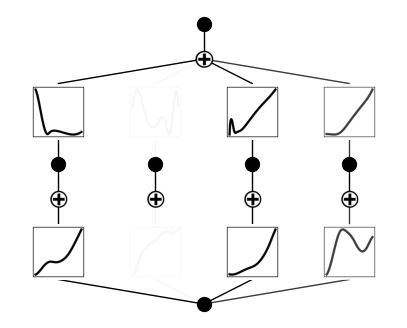

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[1,4,1], grid=7, k=3, seed=17, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: (x**2 + torch.pi) **2
ranges = [-2, 2]
dataset = create_dataset(f, n_var=1, ranges=ranges, train_num=10000, test_num=1000, device=device)
res_kan_training = model.fit(dataset, opt="LBFGS", steps=100);
model.plot()

saving model version 0.2


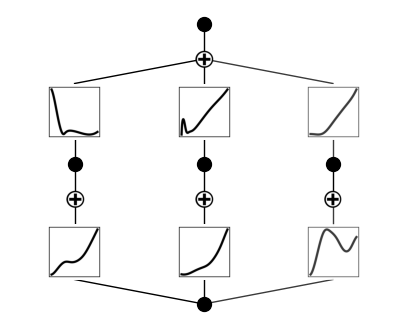

In [6]:
pruned_model = model.prune(node_th=0.2, edge_th=0.2)
pruned_model.plot()

2025-03-11 03:06:45,977 - LLMSR.llmSR - INFO - Processing KAN model connections
2025-03-11 03:06:45,978 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,0)


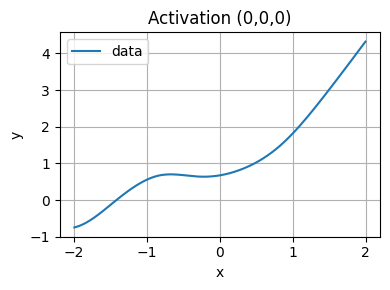

2025-03-11 03:06:46,046 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-11 03:06:46,047 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 1.2028824371456786, for constant: [1.14251912]
2025-03-11 03:06:46,047 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 03:06:47,847 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 03:06:51,285 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 03:06:51,285 - LLMSR.llmSR - INFO - Initial population best: score=-1.5509317299213325, params=[0.81243003 0.42306972 0.26977453 0.2472137 ], ansatz: params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3...
2025-03-11 03:06:51,286 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 03:06:53,064 - LLMSR.llmSR - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can'


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 3
  Success rate: 90.91%

Breakdown by processing stage:
  Api Call: 33 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 31 succeeded, 2 failed (93.94% success)
  Function Conversion: 30 succeeded, 1 failed (96.77% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - no parameters: 2
  Function Errors:
    - syntax error: 1
Approximation for (0,0,0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3 + params[4] * np.sin(x), with parameters [ 0.811  9.125  0.269 -0.944 -8.953]


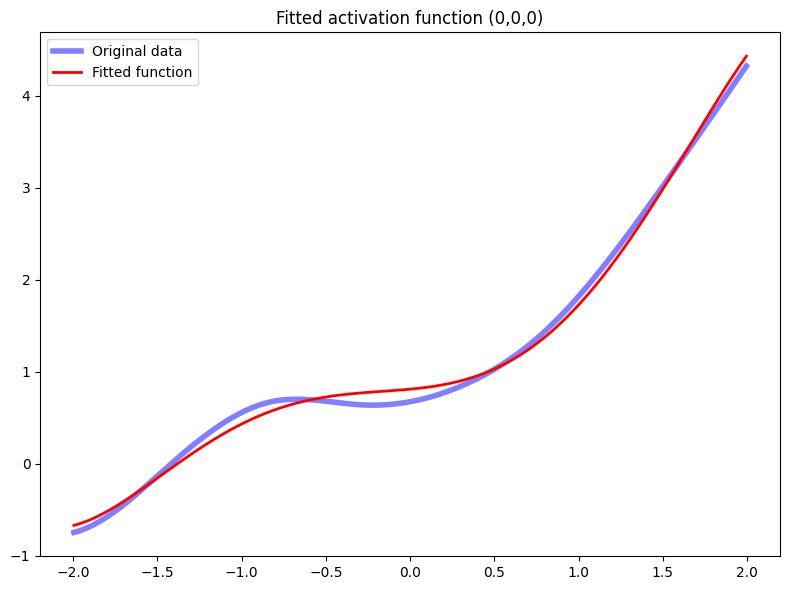

2025-03-11 03:07:08,624 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,1)


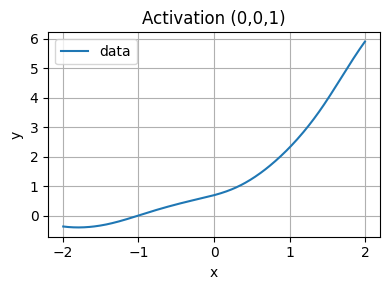

2025-03-11 03:07:08,691 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,1)
2025-03-11 03:07:08,692 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 1.702696715095865, for constant: [1.32758606]
2025-03-11 03:07:08,692 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 03:07:10,468 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 03:07:12,344 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 03:07:12,346 - LLMSR.llmSR - INFO - Initial population best: score=-0.24157193695152188, params=[1.37214766 1.3783875 ], ansatz: params[0] + params[1] * x...
2025-03-11 03:07:12,350 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 03:07:15,545 - LLMSR.llmSR - INFO - Generation 1 best: score=-26.674221454029816, params=[0.68127816 1.39901887 0.50636694], ansatz: params[0] + params[1] * x + params[2] * x


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 1
  Success rate: 96.77%

Breakdown by processing stage:
  Api Call: 31 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 31 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 1 failed (96.77% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Function Errors:
    - syntax error: 1
Approximation for (0,0,1): params[0] + params[1] * x, with parameters [1.372 1.378]


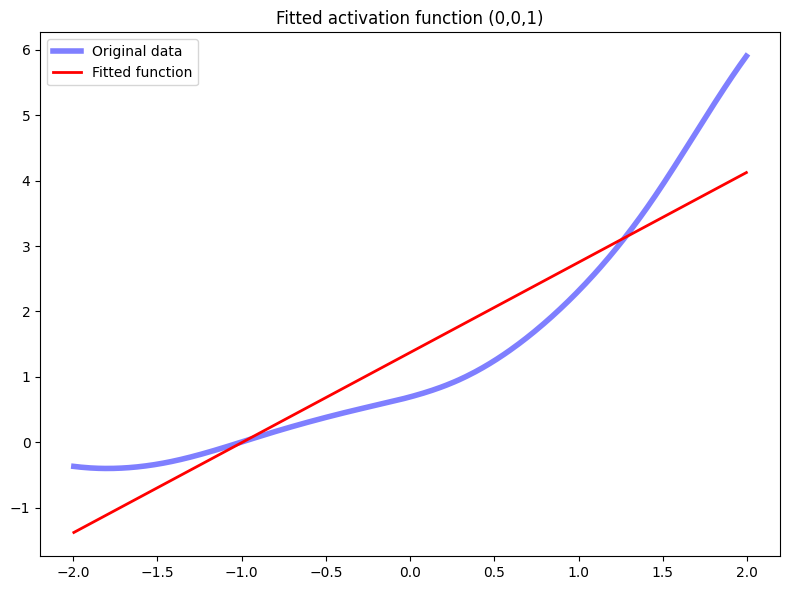

2025-03-11 03:07:23,401 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,2)


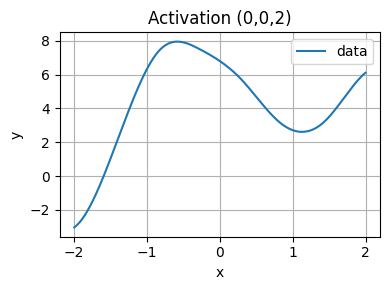

2025-03-11 03:07:23,466 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,2)
2025-03-11 03:07:23,467 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.4758056330772942, for constant: [4.2111055]
2025-03-11 03:07:23,467 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 03:07:27,601 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 03:07:27,602 - LLMSR.llmSR - INFO - Initial population best: score=-0.6314286517914492, params=[4.2337788  0.70133475], ansatz: params[0] + params[1] * x...
2025-03-11 03:07:27,603 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 03:07:30,823 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.7236413574103627, params=[-1.49788778 -4.50016225  4.22153078], ansatz: params[0] * np.sin(params[1] * x) + params[2]...
2025-03-11 03:07:30,824 - LLMSR.llmSR - INFO - Generation 2/2: Generating 10 new individuals. Async? T


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 1
  Success rate: 96.77%

Breakdown by processing stage:
  Api Call: 31 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 1 failed (96.77% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - no parameters: 1
Approximation for (0,0,2): params[0] + params[1] * x, with parameters [4.234 0.701]


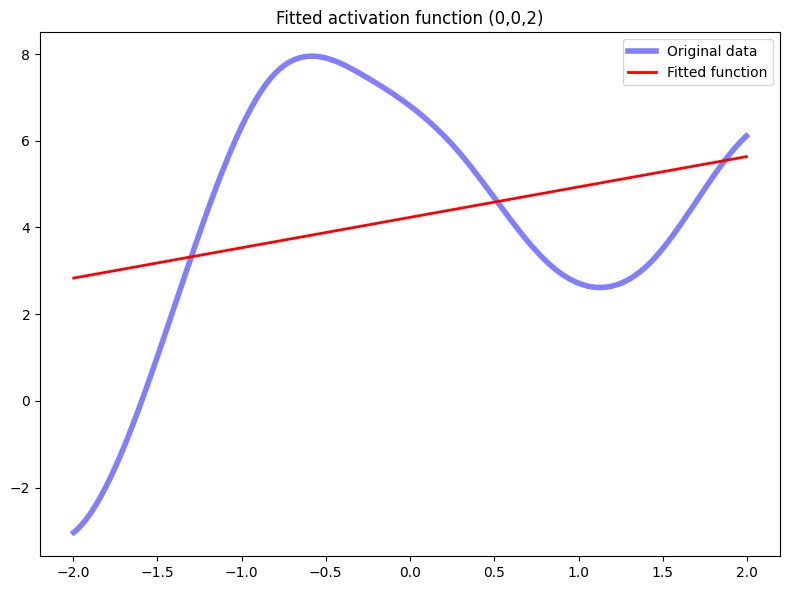

2025-03-11 03:07:34,797 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,0,0)


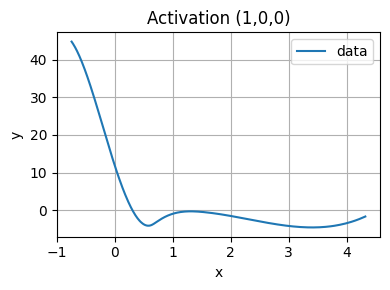

2025-03-11 03:07:34,861 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-11 03:07:34,862 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 17.89739634245125, for constant: [3.25864599]
2025-03-11 03:07:34,863 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 03:07:37,239 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 03:07:37,240 - LLMSR.llmSR - INFO - Initial population best: score=-2.196247594781837, params=[-6.41582045 10.58884374], ansatz: params[0] * x + params[1]...
2025-03-11 03:07:37,241 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 03:07:40,327 - LLMSR.llmSR - INFO - Generation 1 best: score=-2.2233234507321153, params=[-2.55851789e+05  2.50724678e-05  2.55862377e+05], ansatz: params[0] * np.exp(params[1] * x) + params[2]...
2025-03-11 03:07:40,328 - LLMSR.llmSR - INFO - Generation 2/2: Generating 10 new individu


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 30 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
Approximation for (1,0,0): params[0] * x + params[1], with parameters [-6.416 10.589]


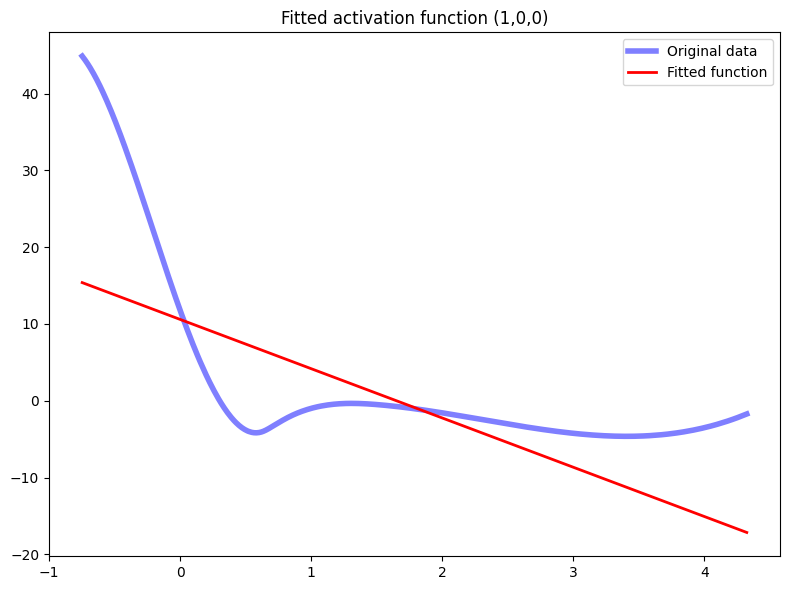

2025-03-11 03:07:43,079 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,1,0)


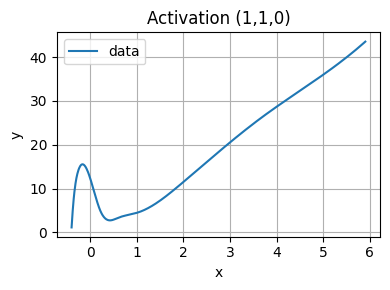

2025-03-11 03:07:43,155 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,1,0)
2025-03-11 03:07:43,156 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.8154545070770165, for constant: [12.0078058]
2025-03-11 03:07:43,157 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 03:07:45,926 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 03:07:45,926 - LLMSR.llmSR - INFO - Initial population best: score=-0.3659535318480792, params=[-0.94116055 -0.41323334  1.20194326  5.94700895], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3]...
2025-03-11 03:07:45,927 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
<string>:1: RuntimeWarning: invalid value encountered in log
2025-03-11 03:07:49,099 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.21742247882789983, params=[ 3.02554588 -1.37686415 -0.04157791  1.43325869  6.40848937], ansatz:


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 30 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
Approximation for (1,1,0): params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4] * x + params[5], with parameters [ 7.767 -1.262  0.535 -3.112  7.67   7.022]


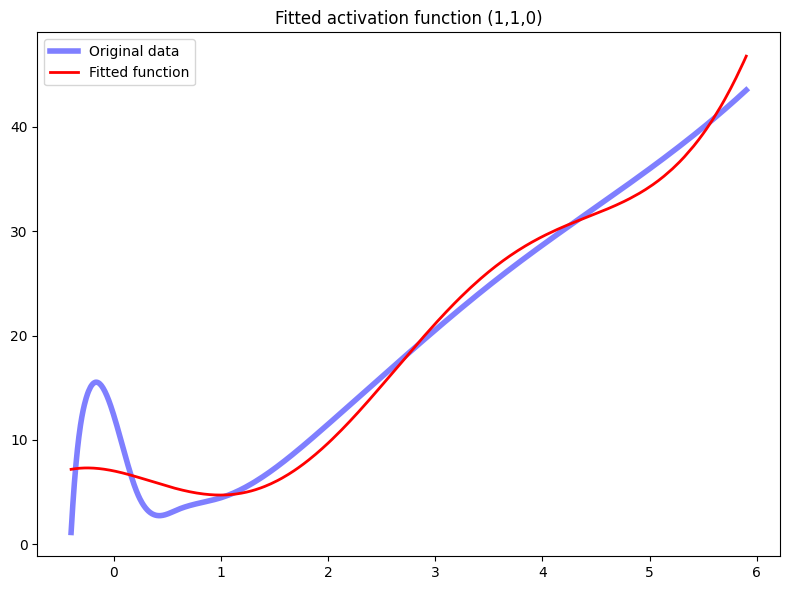

2025-03-11 03:07:53,160 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,2,0)


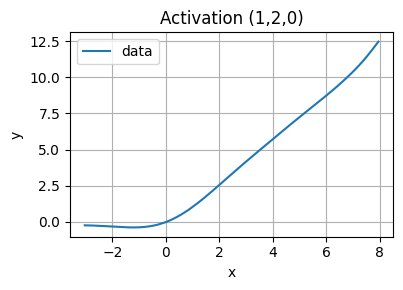

2025-03-11 03:07:53,238 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,2,0)
2025-03-11 03:07:53,239 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.36848030096947115, for constant: [6.45701095]
2025-03-11 03:07:53,239 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 03:07:54,930 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 03:07:56,662 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 03:07:56,662 - LLMSR.llmSR - INFO - Initial population best: score=-0.8939336098311228, params=[0.89154284 1.32161688], ansatz: params[0] + params[1] * x...
2025-03-11 03:07:56,663 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 03:07:59,397 - LLMSR.llmSR - INFO - Generation 1 best: score=-2.817427949276555, params=[0.8941494  0.84540395 0.07652636], ansatz: params[0] + params[1] * x + params[2] * x


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 1
  Success rate: 96.77%

Breakdown by processing stage:
  Api Call: 31 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 31 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 1 failed (96.77% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Function Errors:
    - syntax error: 1
Approximation for (1,2,0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3, with parameters [ 0.494  0.804  0.151 -0.008]


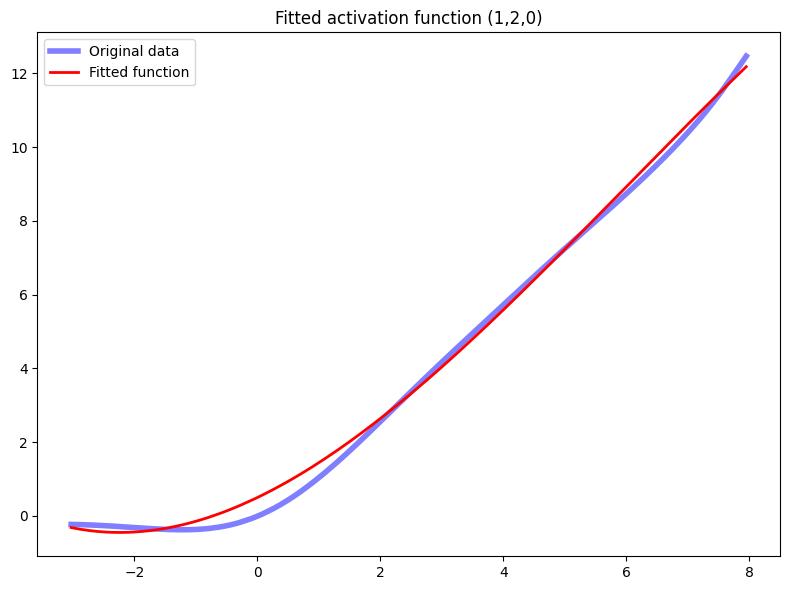

2025-03-11 03:08:02,573 - LLMSR.llmSR - INFO - KAN conversion complete: 6 total connections
2025-03-11 03:08:02,573 - LLMSR.llmSR - INFO - Connection breakdown: 0 symbolic, 0 zero, 6 processed


In [7]:
sym_expr = LLMSR.kan_to_symbolic(pruned_model, client, gpt_model="openai/gpt-4o", exit_condition=min(res_kan_training['train_loss']).item())


In [8]:
symb_expr_sorted = {}
# build disctionary with all expressions ordered by score
for kan_conn, sub_res in sym_expr.items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    print(len(sub_res))
    ordered_elements = sorted([item for sublist in sub_res for item in sublist], key=lambda item: -item['score'])
    print(len(ordered_elements))
    symb_expr_sorted[kan_conn] = ordered_elements
    print(f"Approximation for {kan_conn}: {ordered_elements[0]['ansatz'].strip()}")
    print(f"Parameters are {np.round(ordered_elements[0]['params'], 1)}")

3
30
Approximation for (0, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3 + params[4] * np.sin(x)
Parameters are [ 0.8  9.1  0.3 -0.9 -9. ]
3
30
Approximation for (0, 0, 1): params[0] + params[1] * x
Parameters are [1.4 1.4]
3
30
Approximation for (0, 0, 2): params[0] + params[1] * x
Parameters are [4.2 0.7]
3
30
Approximation for (1, 0, 0): params[0] * x + params[1]
Parameters are [-6.4 10.6]
3
30
Approximation for (1, 1, 0): params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4] * x + params[5]
Parameters are [ 7.8 -1.3  0.5 -3.1  7.7  7. ]
3
30
Approximation for (1, 2, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Parameters are [ 0.5  0.8  0.2 -0. ]


In [9]:
edge_dict_top_three, edge_dict = {}, {}
for kan_conn, sub_res in symb_expr_sorted.items():
    print(f"KAN Connection: {kan_conn}")
    scores, ansatze, params = [pop['score'] for pop in sub_res], [pop['ansatz'].replace('*x', ' * x').replace('(x)', '(1. * x)') for pop in sub_res], [pop['params'] for pop in sub_res]
    top_three_ansatze, top_three_params, top_three_scores = [], [], []
    for s, a, p in zip(scores, ansatze, params):
        a = a.strip()
        # weed out lambda functions
        if "lambda" in a:
            continue
        if a not in top_three_ansatze and round(s, 5) not in top_three_scores:
            top_three_ansatze.append(a)
            top_three_params.append(p)
            top_three_scores.append(round(s, 5))                
        if len(top_three_ansatze) >= 3:
            break
    top_three = []
    for a, p in zip(top_three_ansatze, top_three_params):
        top_three.append(subst_params(a, p))
    edge_dict_top_three[kan_conn] = top_three
    edge_dict[kan_conn] = top_three[0]
    print([(s,t) for s,t in zip(top_three, top_three_scores)])

KAN Connection: (0, 0, 0)
[('0.8106 + 9.1249 * x + 0.2687 * x**2 + -0.9439 * x**3 + -8.9529 * np.sin(1. * x)', np.float64(-0.46658)), ('0.8105 + 0.1795 * x + 0.2688 * x**2 + 0.5302 * x**3 + -0.0641 * x**5', np.float64(-0.62856)), ('2.4627 + 2.2294 * x + -1.8635 * np.sin(1. * x) + -1.7355 * np.cos(1. * x) + -0.3779 * x**2', np.float64(-0.79327))]
KAN Connection: (0, 0, 1)
[('1.3721 + 1.3784 * x', np.float64(-0.24157)), ('0.6688 + 0.9906 * x + 0.5183 * x**2 + 0.1702 * x**3', np.float64(-5.50188)), ('1.3274 * np.exp(0.8153 * x) + -0.6393', np.float64(-7.78983))]
KAN Connection: (0, 0, 2)
[('4.2338 + 0.7013 * x', np.float64(-0.63143)), ('-1.4979 * np.sin(-4.5002 * x) + 4.2215', np.float64(-0.72364)), ('6.4421 + -3.0319 * x + -1.5939 * x**2 + 1.5267 * x**3', np.float64(-0.89406))]
KAN Connection: (1, 0, 0)
[('-6.4158 * x + 10.5888', np.float64(-2.19625)), ('-255851.7890 * np.exp(0.0000 * x) + 255862.3775', np.float64(-2.22332)), ('-273779.9569 * np.exp(0.0000 * x) + 4.5404 * np.cos(-3.2469 

###################################################
Simplifying output 0
KAN expression (raw):
 7.4543374292149*x0**3 - 3.42997512405144*x0**2 - 54.4357834678521*x0 + 57.44001582*sin(1.0*x0) - 7.7671*sin(1.73995432*x0 + 1.73200183) + 24.4190400623896
KAN expression (simplified):
 7.4543*x0**3 - 3.43*x0**2 - 54.4358*x0 + 57.44*sin(1.0*x0) - 7.7671*sin(1.74*x0 + 1.732) + 24.419
Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Proceeding with unoptimized parameters
KAN expression (final):
 7.4543*x0**3 - 3.43*x0**2 - 54.4358*x0 + 57.44*sin(1.0*x0) - 7.7671*sin(1.74*x0 + 1.732) + 24.419
'ImmutableDenseNDimArray' object has no attribute 'as_coefficient'
Skipping LLM improvement.


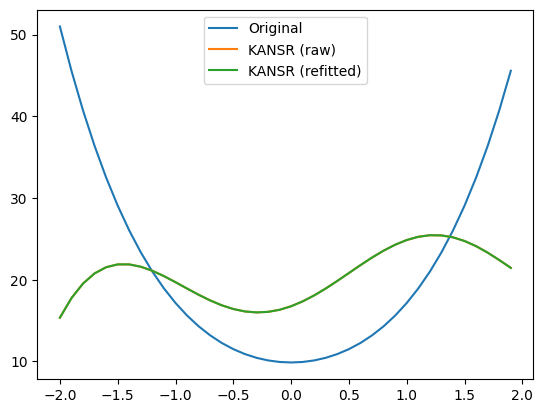

##################
# Final formula: #
##################
 7.4543*x0**3 - 3.43*x0**2 - 54.4358*x0 + 57.44*x0 - 7.7671*(0.987*sin(1.74*x0) + 0.161608) + 24.419


In [10]:
# define an expression tree consisting of L layers, with N nodes, where node (l,n) = \sum_c expr(l,c,n)
# the KAN convention for the triples (l,c,n) is: (layer, coming from node in l-1, going to node in layer l)
node_tree = {}
for l in range(len(pruned_model.width_in) - 1):
        for n in range(pruned_model.width_in[l+1]):
            node_tree[(l, n)] = " + ".join([edge_dict[(l,c,n)].replace(' x', f' x[{l-1},{c}]' if l > 0 else f' x{c}') for c in range(pruned_model.width_out[l])])
for k, v in node_tree.items():
    node_tree[k] = v.replace('+ -','- ')
# Build full expression, prepopulate with output nodes
full_expression = []
for o in range(pruned_model.width_in[-1]):
    res = node_tree[len(pruned_model.width_in)-2, o]
    # traverse down lower layers
    for l in list(range(len(pruned_model.width_in)-2))[::-1]:
        for n in range(len([x for x in node_tree.keys() if x[0]==l])):
            res = res.replace(f'x[{l},{n}]', f'({node_tree[l, n]})')
    full_expression.append(simplify_expression(res, pruned_model.width_in[0] - 1))

# After simplification, prune (round coefficients to 4 digits), simplify again
final_expressions = []
for i, expr in enumerate(full_expression):
    print("###################################################")
    print(f"Simplifying output {i}")
    print("KAN expression (raw):\n", expr)
    f_fitted = lambda x0: eval(expr)
    xs = np.arange(-2, 2, .1)
    plt.plot(xs, [f(x) for x in xs], label="Original")
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (raw)")
    plt.legend();
    
    # prune and simplify
    expr = simplify_expression(subst_params(*replace_floats_with_params(expr)), pruned_model.width_in[0] - 1)
    print("KAN expression (simplified):\n", expr)

    # refit parameters
    curve_ansatz_str, params_initial = replace_floats_with_params(expr)
    for k, v in sympy_to_numpy.items():
        curve_ansatz_str = curve_ansatz_str.replace(k, v)
    
    curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
    curve = eval(curve_ansatz)
    try:
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")
    except RuntimeError as e:
        print(e)
        print("Proceeding with unoptimized parameters")
        params_opt = params_initial

    # prune and simplify refitted model
    expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
    print("KAN expression (final):\n", expr)
    final_expressions.append(expr)
    
    # plot comparison
    f_fitted = lambda x0: eval(expr)
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (refitted)")
    
    # Ask LLM to further simplify the result and refit.
    try:
        simp_call_reply = call_model_simplify(client, prompt=f"The interval is {ranges}. The function is {expr}.")
        expr = simp_call_reply.choices[0].message.content
        curve_ansatz_str, params_initial = replace_floats_with_params(expr)
        curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
        curve = eval(curve_ansatz)
        
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")    
        expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
        f_fitted = lambda x0: eval(expr)
        plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (final)")
    except Exception as e:
        print(e)
        print("Skipping LLM improvement.")
    
    plt.legend()
    plt.show()
    print("##################\n# Final formula: #\n##################\n", expr)

# Try $e^{1.83169-3.35509/x}$

/var/folders/n5/4xlf9f2j41z1r42htkz4vw0m0000gn/T/ipykernel_38867/626955180.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.exp(1.83169-3.35509/x)


cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.90e-06 | test_loss: 5.76e-06 | reg: 9.11e+00 | : 100%|█| 50/50 [00:22<00:00,  2.19it


saving model version 0.1


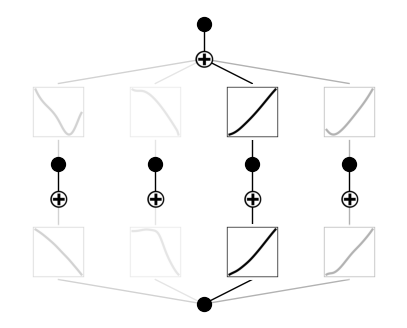

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[1,4,1], grid=7, k=3, seed=17, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: np.exp(1.83169-3.35509/x)
ranges = [0.1, 2.]
dataset = create_dataset(f, n_var=1, ranges=ranges, train_num=10000, test_num=1000, device=device)
res_kan_training = model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

saving model version 0.2


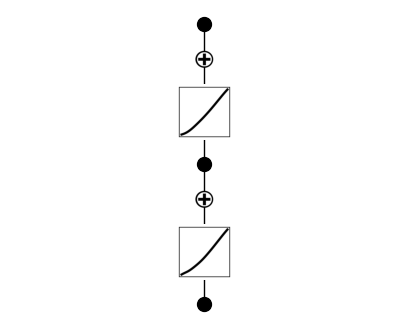

In [ ]:
pruned_model = model.prune(node_th=0.2, edge_th=0.2)
pruned_model.plot()

2025-03-11 00:59:00,721 - LLMSR.llmSR - INFO - Processing KAN model connections
2025-03-11 00:59:00,723 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,0)


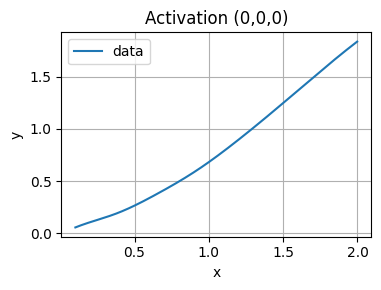

2025-03-11 00:59:00,901 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-11 00:59:00,902 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.4619954353361316, for constant: [0.79980108]
2025-03-11 00:59:00,902 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 00:59:02,628 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 00:59:04,814 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 00:59:04,815 - LLMSR.llmSR - INFO - Initial population best: score=-0.053281708206767066, params=[0.81743689], ansatz: params[0] * x...
2025-03-11 00:59:04,816 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 00:59:10,522 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.001899599192725625, params=[0.42725349 0.26022499], ansatz: params[0] * x + params[1] * x**2...
2025-03-11 00:59:10,523 - LLMSR.llm


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 1
  Success rate: 96.77%

Breakdown by processing stage:
  Api Call: 31 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 31 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 1 failed (96.77% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Function Errors:
    - syntax error: 1
Approximation for (0,0,0): params[0] * x**2 + params[1] * x, with parameters [0.26  0.427]


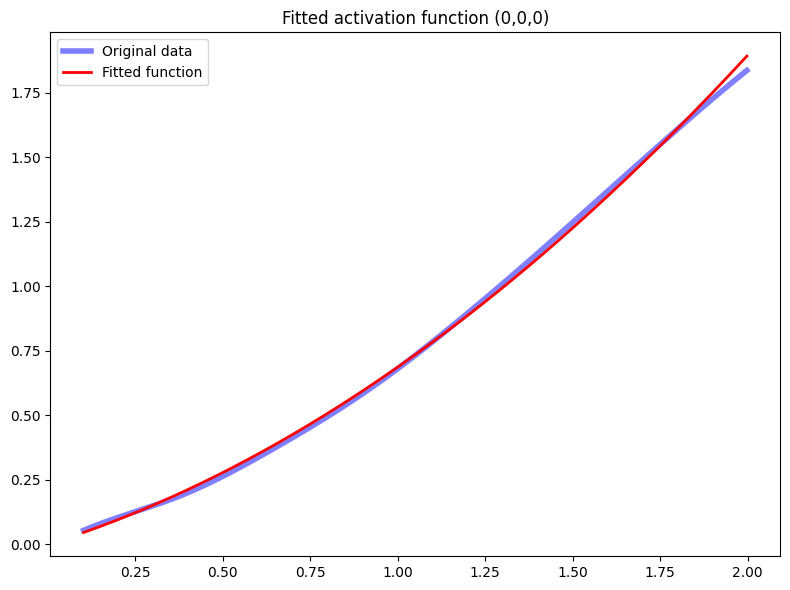

2025-03-11 00:59:14,210 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,0,0)


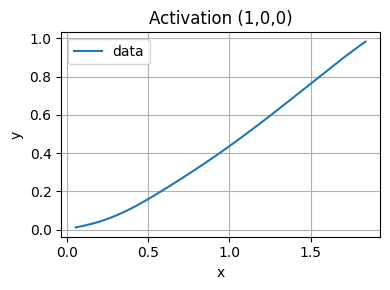

2025-03-11 00:59:14,275 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-11 00:59:14,276 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.7344088168706323, for constant: [0.35624705]
2025-03-11 00:59:14,276 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 00:59:15,883 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 00:59:17,882 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 00:59:17,883 - LLMSR.llmSR - INFO - Initial population best: score=-0.12183195525683699, params=[0.4811723], ansatz: params[0] * x...
2025-03-11 00:59:17,884 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 00:59:24,194 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.026405682136134662, params=[0.16016566 0.2632122 ], ansatz: params[0] * x**2 + params[1] * x...
2025-03-11 00:59:24,195 - LLMSR.llmSR


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 1
  Success rate: 96.77%

Breakdown by processing stage:
  Api Call: 31 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 31 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 1 failed (96.77% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  Function Errors:
    - syntax error: 1
Approximation for (1,0,0): params[0] * x**3 + params[1] * x**2 + params[2] * x, with parameters [-0.091  0.375  0.152]


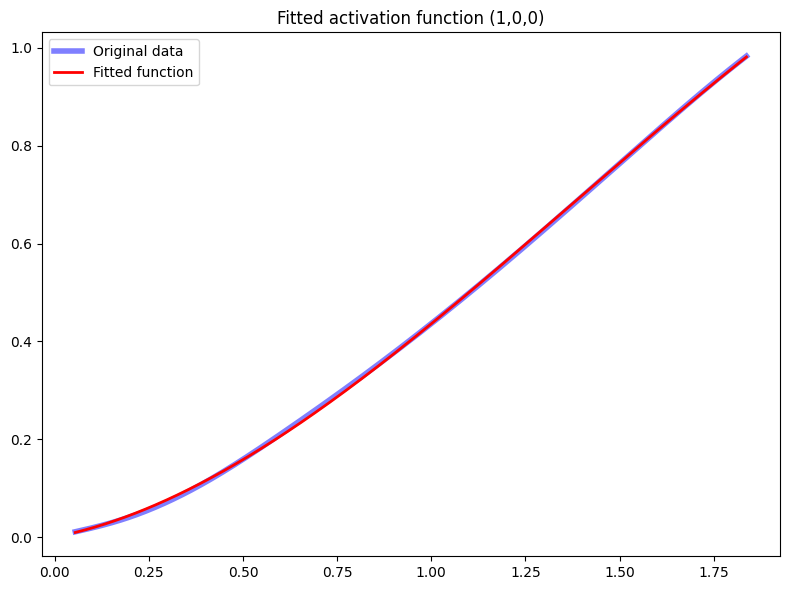

2025-03-11 00:59:26,621 - LLMSR.llmSR - INFO - KAN conversion complete: 2 total connections
2025-03-11 00:59:26,622 - LLMSR.llmSR - INFO - Connection breakdown: 0 symbolic, 0 zero, 2 processed


In [19]:
sym_expr = LLMSR.kan_to_symbolic(pruned_model, client, gpt_model="openai/gpt-4o", exit_condition=min(res_kan_training['train_loss']).item())

In [20]:
symb_expr_sorted = {}
# build disctionary with all expressions ordered by score
for kan_conn, sub_res in sym_expr.items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    ordered_elements = sorted([item for sublist in sub_res for item in sublist], key=lambda item: -item['score'])
    symb_expr_sorted[kan_conn] = ordered_elements
    print(f"Approximation for {kan_conn}: {ordered_elements[0]['ansatz'].strip()}")
    print(f"Parameters are {np.round(ordered_elements[0]['params'], 1)}")

Approximation for (0, 0, 0): params[0] * x**2 + params[1] * x
Parameters are [0.3 0.4]
Approximation for (1, 0, 0): params[0] * x**3 + params[1] * x**2 + params[2] * x
Parameters are [-0.1  0.4  0.2]


In [8]:
edge_dict_top_three, edge_dict = {}, {}
for kan_conn, sub_res in symb_expr_sorted.items():
    print(f"KAN Connection: {kan_conn}")
    scores, ansatze, params = [pop['score'] for pop in sub_res], [pop['ansatz'].replace('*x', ' * x').replace('(x)', '(1. * x)') for pop in sub_res], [pop['params'] for pop in sub_res]
    top_three_ansatze, top_three_params, top_three_scores = [], [], []
    for s, a, p in zip(scores, ansatze, params):
        a = a.strip()
        # weed out lambda functions
        if "lambda" in a:
            continue
        if a not in top_three_ansatze and round(s, 5) not in top_three_scores:
            top_three_ansatze.append(a)
            top_three_params.append(p)
            top_three_scores.append(round(s, 5))                
        if len(top_three_ansatze) >= 3:
            break
    top_three = []
    for a, p in zip(top_three_ansatze, top_three_params):
        top_three.append(subst_params(a, p))
    edge_dict_top_three[kan_conn] = top_three
    edge_dict[kan_conn] = top_three[0]
    print([(s,t) for s,t in zip(top_three, top_three_scores)])

NameError: name 'symb_expr_sorted' is not defined

In [7]:
node_tree

NameError: name 'node_tree' is not defined

###################################################
Simplifying output 0
KAN expression (raw):
 x0*(-0.0015995864816864*x0**5 - 0.0078805146459408*x0**4 + 0.0124476471744408*x0**3 + 0.0763034975469364*x0**2 + 0.10796784375*x0 + 0.06486414)
KAN expression (simplified):
 x0*(-0.0016*x0**5 - 0.0079*x0**4 + 0.0124*x0**3 + 0.0763*x0**2 + 0.108*x0 + 0.0649)
Refitting gave a chi^2 of 2.5611e-01
KAN expression (final):
 x0*(0.0325*x0**5 - 0.0633*x0**4 - 0.3618*x0**3 + 1.1639*x0**2 - 0.6484*x0 + 0.0943)
Refitting gave a chi^2 of 6.0094e-01


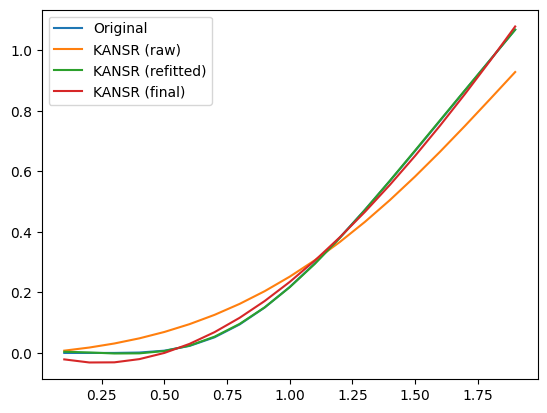

##################
# Final formula: #
##################
 x0*(-0.0705*x0**2 + 0.5745*x0 - 0.2693)


In [ ]:
# define an expression tree consisting of L layers, with N nodes, where node (l,n) = \sum_c expr(l,c,n)
# the KAN convention for the triples (l,c,n) is: (layer, coming from node in l-1, going to node in layer l)
node_tree = {}
for l in range(len(pruned_model.width_in) - 1):
        for n in range(pruned_model.width_in[l+1]):
            node_tree[(l, n)] = " + ".join([edge_dict[(l,c,n)].replace(' x', f' x[{l-1},{c}]' if l > 0 else f' x{c}') for c in range(pruned_model.width_out[l])])
for k, v in node_tree.items():
    node_tree[k] = v.replace('+ -','- ')

# Build full expression, prepopulate with output nodes
full_expression = []
for o in range(pruned_model.width_in[-1]):
    res = node_tree[len(pruned_model.width_in)-2, o]
    # traverse down lower layers
    for l in list(range(len(pruned_model.width_in)-2))[::-1]:
        for n in range(len([x for x in node_tree.keys() if x[0]==l])):
            res = res.replace(f'x[{l},{n}]', f'({node_tree[l, n]})')
    full_expression.append(simplify_expression(res, pruned_model.width_in[0] - 1))

# After simplification, prune (round coefficients to 4 digits), simplify again
final_expressions = []
for i, expr in enumerate(full_expression):
    print("###################################################")
    print(f"Simplifying output {i}")
    print("KAN expression (raw):\n", expr)
    f_fitted = lambda x0: eval(expr)
    xs = np.arange(ranges[0], ranges[1], .1)
    plt.plot(xs, [f(x) for x in xs], label="Original")
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (raw)")
    plt.legend();
    
    # prune and simplify
    expr = simplify_expression(subst_params(*replace_floats_with_params(expr)), pruned_model.width_in[0] - 1)
    print("KAN expression (simplified):\n", expr)

    # refit parameters
    curve_ansatz_str, params_initial = replace_floats_with_params(expr)
    for k, v in sympy_to_numpy.items():
        curve_ansatz_str = curve_ansatz_str.replace(k, v)
    
    curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
    curve = eval(curve_ansatz)
    try:
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")
    except RuntimeError as e:
        print(e)
        print("Proceeding with unoptimized parameters")
        params_opt = params_initial

    # prune and simplify refitted model
    expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
    print("KAN expression (final):\n", expr)
    final_expressions.append(expr)
    
    # plot comparison
    f_fitted = lambda x0: eval(expr)
    plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (refitted)")
    
    # Ask LLM to further simplify the result and refit.
    try:
        simp_call_reply = call_model_simplify(client, prompt=f"The interval is {ranges}. The function is {expr}.")
        expr = simp_call_reply.choices[0].message.content
        curve_ansatz_str, params_initial = replace_floats_with_params(expr)
        curve_ansatz = "lambda x0, *params: " + curve_ansatz_str
        curve = eval(curve_ansatz)
        
        params_opt, chi_squared = fit_curve(dataset['train_input'].numpy().flatten(), dataset['train_label'].numpy().flatten(), curve, params_initial)
        print(f"Refitting gave a chi^2 of {chi_squared:.4e}")    
        expr = simplify_expression(subst_params(curve_ansatz_str, params_opt), pruned_model.width_in[0] - 1)
        f_fitted = lambda x0: eval(expr)
        plt.plot(xs, [f_fitted(x) for x in xs], label="KANSR (final)")
    except Exception as e:
        print(e)
        print("Skipping LLM improvement.")
    
    plt.legend()
    plt.show()
    print("##################\n# Final formula: #\n##################\n", expr)